# **Excercise 1: Encoding-LIF-STDP functions**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

DELTA_T = 1e-3
duration = 0.5

In [ ]:
def rate_encoding(signal, time_step=DELTA_T, max_rate=100):
    """
    Biến đổi tín hiệu liên tục thành spike train dùng Poisson rate coding.

    Parameters:
    - signal: mảng giá trị liên tục (0 đến 1)
    - dt: time step (giây)
    - max_rate: tốc độ bắn spike tối đa (Hz)

    Returns:
    - spikes: spike train (0 hoặc 1) với cùng chiều dài như signal
    """
    signal = np.clip(signal, 0, 1)
    spike_prob = signal * max_rate * time_step
    # print(f"spike_prob = {spike_prob}")
    return np.random.rand(*signal.shape) < spike_prob


np.random.seed(42)
a = np.random.rand(int(duration/DELTA_T))
spike_train = rate_encoding(a)
print(f"Number of spikes: {spike_train.sum()}")
print(f"Len of signal: {len(spike_train)}")



Number of spikes: 16
Len of signal: 500


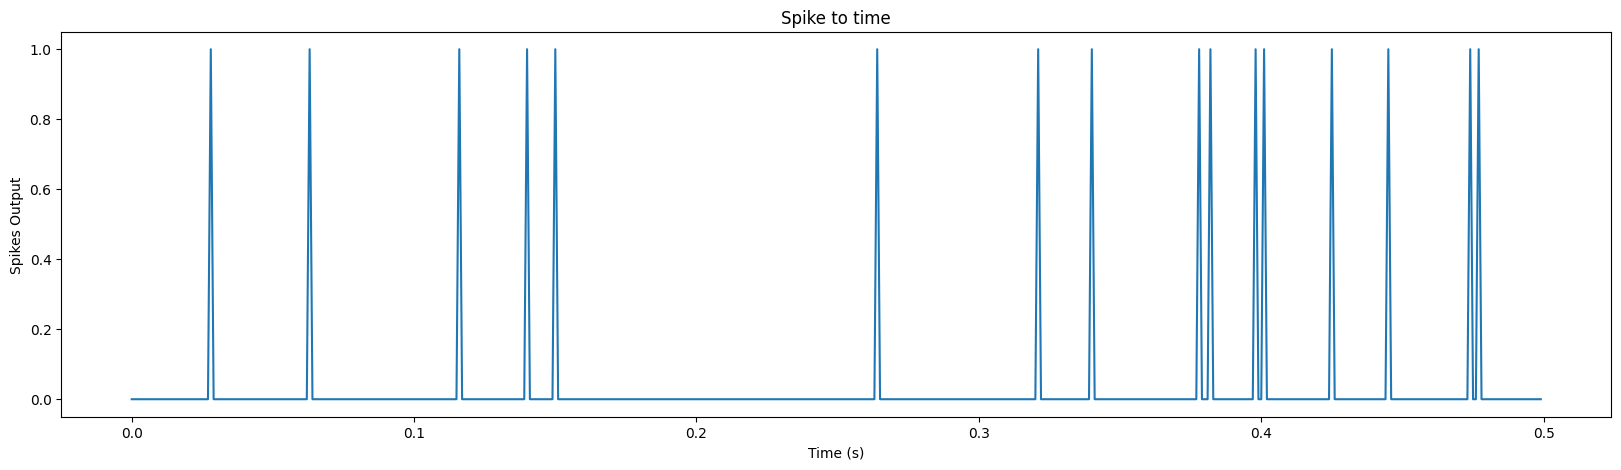

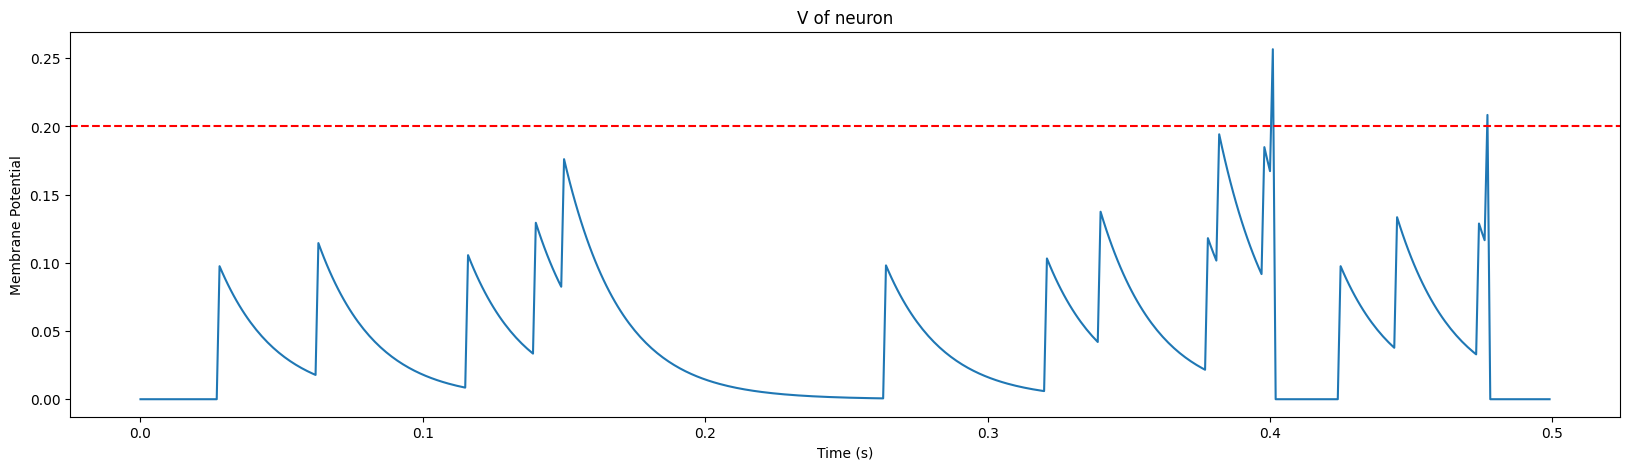

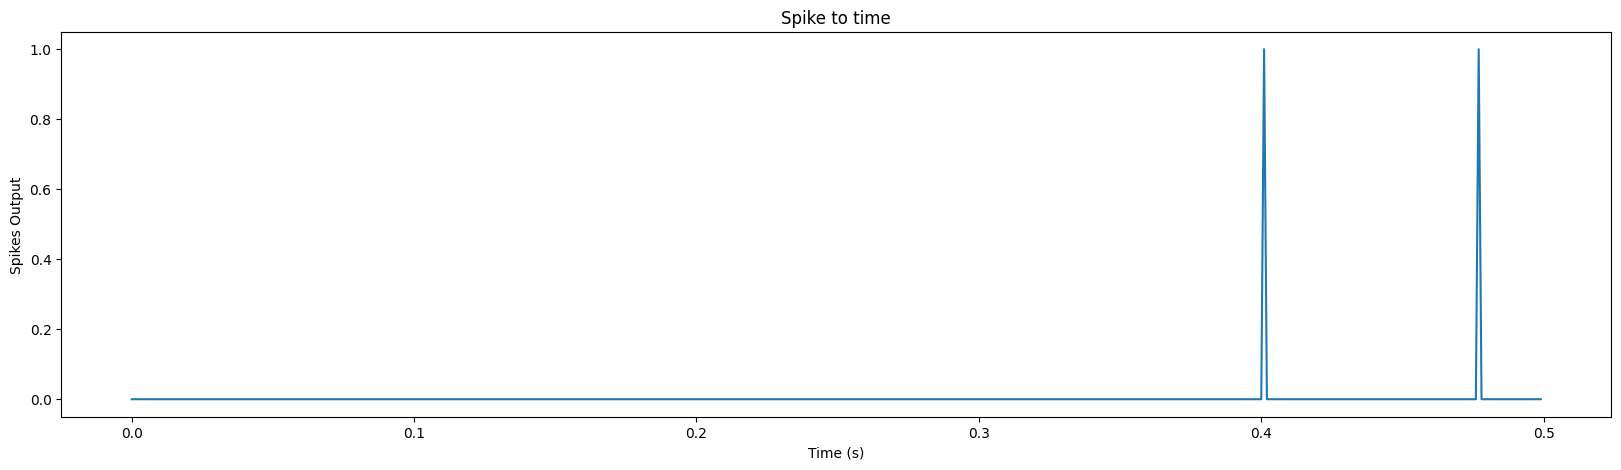

In [ ]:
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, tau=20*DELTA_T, R=1, V_th=0.2, dt=DELTA_T):
        self.tau = tau # ảnh hưởng tới tốc độ tích/suy giảm điện thế của neuron
        self.R = R # 1 tham số để tính V
        self.V_th = V_th # ngưỡng V tối thiểu để neuron bắn xung, nếu vượt thì reset lại về V_reset=0
        self.dt = dt # delta t, chọn trùng với delta t của rate_encoding
        self.V = 0 # ngưỡng điện thế ban đầu
        self.spikes = [] # thời điểm bắn xung(1) hoặc không bắn xung(0)

    def reset(self):
        self.V = 0
        self.spikes.append(1)

    def update_V(self, I):
        beta = np.exp(-self.dt/self.tau)
        self.V = beta*self.V + (1-beta)*I*self.R


    def simulate(self, spike_train, duration):
        time = np.arange(0, duration, self.dt)
        V_trace = []
        self.spikes = []

        for t in time:
            I = 0
            # nếu có xung vào thì tăng điện thế
            if spike_train[int(t/self.dt)] == 1:
                I = 2.5

            # calculate and update V at the time t with I
            self.update_V(I)

            # nếu vượt ngưỡng điện tích thì bắn xung và reset giá trị
            V_trace.append(self.V)
            if self.V >= self.V_th:
                self.reset()
            else:
                self.spikes.append(0)


        return time, V_trace, self.spikes


# Test with step current
neuron = LIFNeuron()
time, V, spikes = neuron.simulate(spike_train=spike_train, duration=len(spike_train)*1e-3)

# plot
def plot_spike_to_time(spike_train, time):
    plt.figure(figsize=(20, 5))
    spike_indices = np.where(spike_train == 1)[0]
    plt.vlines(time[spike_indices], 0, 1, linewidth=1)
    plt.title("Spike train input")
    plt.xlabel("Time (s)")
    plt.ylabel("Spike in")
    plt.yticks([0.00, 0.25,0.50,0.75,1.00])  # Ẩn các đánh dấu trên trục y
    plt.ylim(-0.5, 1.5) # Đặt giới hạn trục y cho rõ ràng
    plt.show()


def plot_V(V, time, V_th, title="V of neuron"):
    plt.figure(figsize=(20, 5))
    plt.plot(time, V)
    plt.axhline(y=V_th, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Membrane Potential")
    plt.show()

def plot_spike(spikes, time, title="Spike to time"):
    plt.figure(figsize=(20, 5))
    plt.plot(time, spikes)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Spikes Output")
    plt.show()


plot_spike(spike_train, time)
plot_V(V, time, neuron.V_th)
plot_spike(spikes, time)


In [ ]:
# STDP functions
class STDP:
    def __init__(self, A_plus=0.01, A_minus=0.011, tau_plus=20*DELTA_T, tau_minus=20*DELTA_T, w_init=0.8, w_max=1, w_min=0):
        self.A_plus = A_plus # độ tăng trọng số của synapse
        self.A_minus = A_minus # độ giảm trọng số của synapse, A_min > A_plus thì tránh overfit, A_min < A_plus thì mạng học nhanh
        self.tau_plus = tau_plus #  hằng số thời gian điều chỉnh tốc độ suy giảm của hiệu ứng theo thời gian
        self.tau_minus = tau_minus
        self.w = w_init
        self.w_min = w_min
        self.w_max = w_max
        self.pre_spike_times = []
        self.post_spike_times = []

    def update(self, t):
        for t_pre in self.pre_spike_times:
            for t_post in self.post_spike_times:
                delta_t = t_post - t_pre
                if delta_t > 0:  # LTP
                    self.w += self.A_plus * np.exp(-delta_t/self.tau_plus)
                elif delta_t < 0:  # LTD
                    self.w -= self.A_minus * np.exp(-abs(delta_t)/self.tau_minus)

        # Prune old spikes
        self.pre_spike_times = [t_pre for t_pre in self.pre_spike_times if (t - t_pre) < 5 * self.tau_plus]
        self.post_spike_times = [t_post for t_post in self.post_spike_times if (t - t_post) < 5 * self.tau_minus]

        # Limit weight
        self.w = np.clip(self.w, self.w_min, self.w_max)
        return self.w

    def new_pre_spike(self, t):
        # self.pre_spike_times.append(t)
        self.pre_spike_times.append(t)
        self.update(t)

    def new_post_spike(self, t):
        # self.post_spike_times.append(t)
        self.post_spike_times.append(t)
        self.update(t)

    def get_weighted_input(self, input_signal):
        return input_signal * self.w

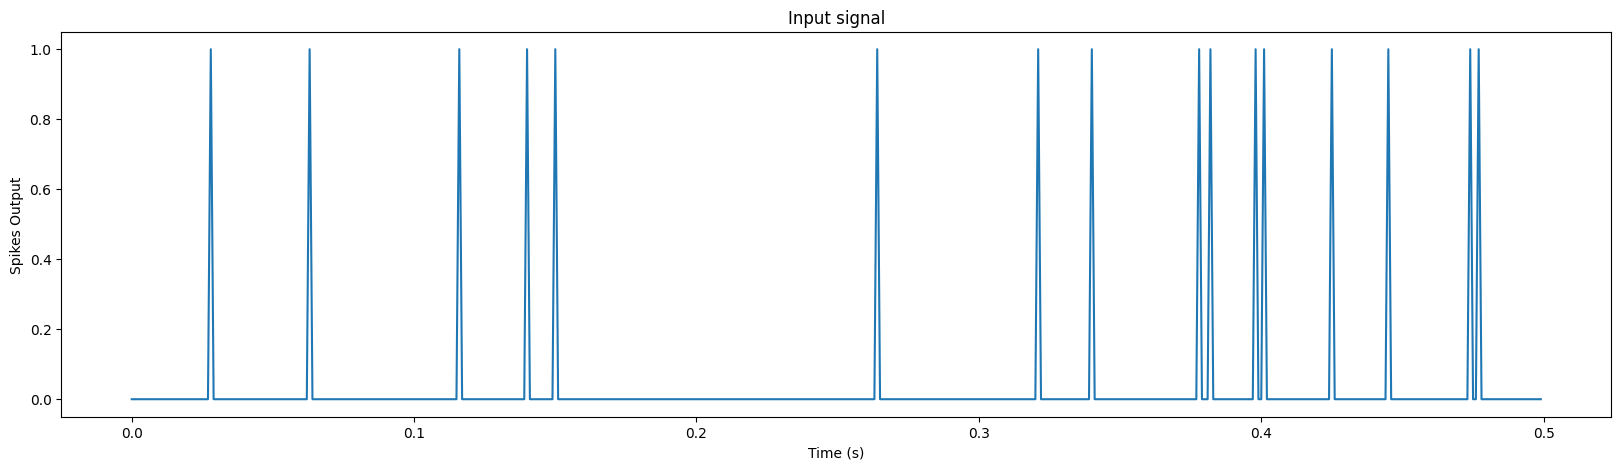

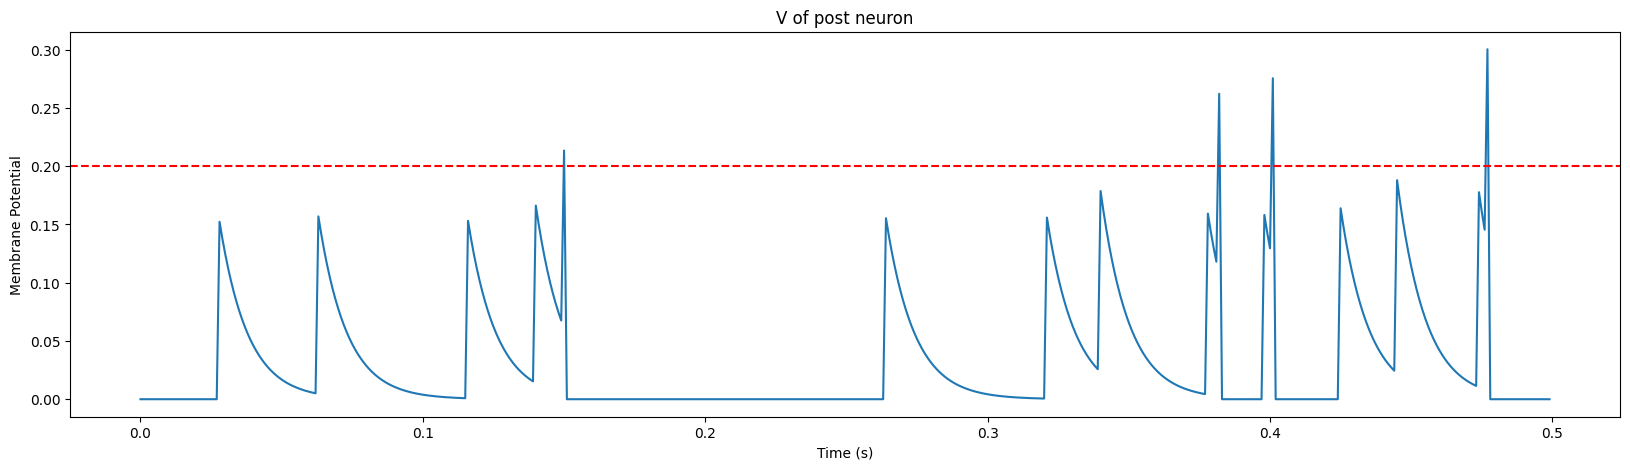

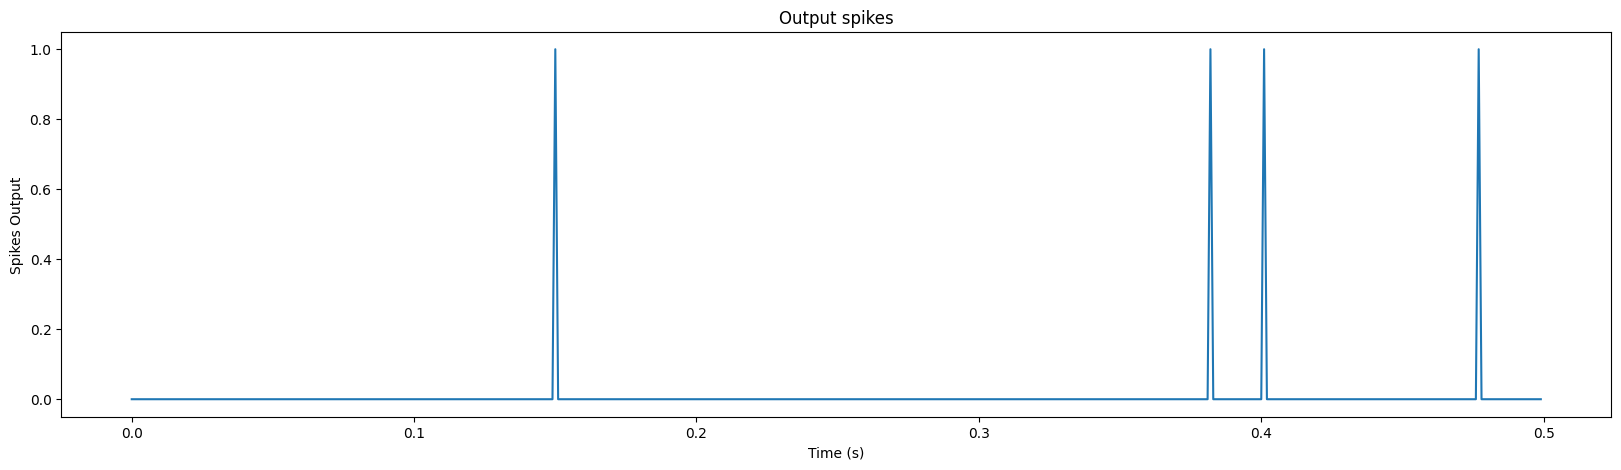

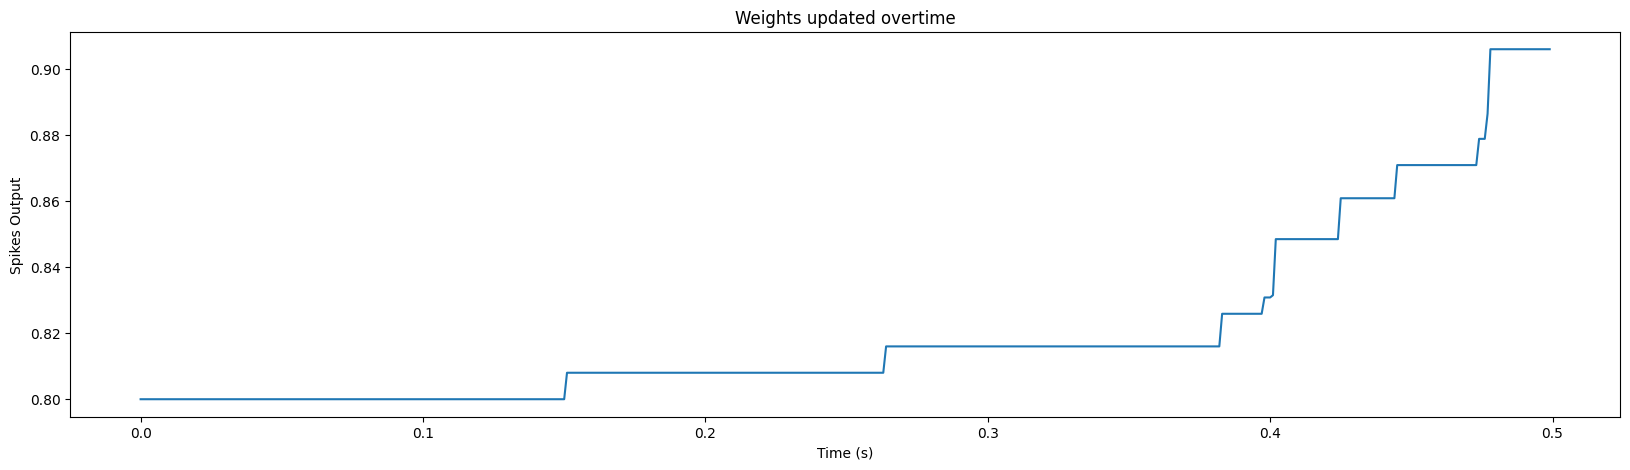

w: 0.9061


In [ ]:
# simulate STDP update with a post neuron and a signal of duration 0.5
def simulate(synapse, neuron, signal, duration):
    # simulated time series
    time = np.arange(0, duration, DELTA_T)
    V_trace = []
    weights = []

    for i, t in enumerate(time):
        signal = spike_train[i]
        if signal == 1:
            synapse.new_pre_spike(t)

        weights.append(synapse.w)
        I = synapse.get_weighted_input(signal)
        # test LTD
        # if i == len(time)/2:
        #     I = 5
        neuron.update_V(I)
        V_trace.append(neuron.V)
        if neuron.V >= neuron.V_th:
            synapse.new_post_spike(t)
            neuron.reset()
        else:
            neuron.spikes.append(0)


    return time, V_trace, neuron.spikes, weights


neuron = LIFNeuron(V_th=0.2, R=2, tau=DELTA_T*10)
synapse = STDP()
duration = 0.5


time, V_trace, spikes, weights = simulate(synapse, neuron, spike_train, duration)


plot_spike(spike_train, time, "Input signal")
plot_V(V_trace, time, neuron.V_th, "V of post neuron")
plot_spike(spikes, time, "Output spikes")
plot_spike(weights, time, "Weights updated overtime")

print(f"w: {synapse.w:.4f}")


Ta thấy đường biểu diễn của weights trong synapse không giảm xuống vì không có trường hợp nào neuron bắn xung mà tín hiệu đầu vào không có xung
 $(t_{pre} > t_{post})$

# **Exercise 2: Implement Spiking CNN for Image Recognition (CSNN) on MNIST (handwritten digits).**

In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 9.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import functional as SF


In [ ]:
# Standard CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) # keep input size -> 16 kernels with size = input size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # -> 16 kernels with size = input size/2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) # -> 32 kernels with size = input size/2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # -> 32 kernels with size = input size/4
        self.fc1 = nn.Linear(32 *7*7, 128) # input size = 28 -> 32x7x7 is flatten to 32*7*7 input units -> output:128
        self.fc2 = nn.Linear(128, 10) # 128 input units -> output:10 (10 classes available)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 7 * 7) # flatten to fit fc1 input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define CSNN from standard CNN
class CSNN(nn.Module):
    def __init__(self, cnn, beta=0.9, spike_grad=None, num_steps=50):
        super(CSNN, self).__init__()
        self.num_steps = num_steps
        self.beta = beta

        # convert cnn to csnn
        self.conv1 = cnn.conv1
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)
        self.pool1 = cnn.pool1

        self.conv2 = cnn.conv2
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)
        self.pool2 = cnn.pool2

        self.fc1 = cnn.fc1
        self.lif3 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)

        self.fc2 = cnn.fc2
        self.lif4 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)

    def forward(self, x):
        # init membrane potentials of 4 lif layers
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # save spikes record
        spike_records = []

        # simulate time series
        for t in range(self.num_steps):
            cur = x[t] # cur.shape = (batch, 1, 28, 28)
            cur = self.conv1(cur) # cur.shape = (batch, 16, 28, 28)
            spikes, mem1 = self.lif1(cur, mem1)
            cur = self.pool1(spikes) # cur.shape = (batch, 16, 14, 14)

            cur = self.conv2(cur)
            spikes, mem2 = self.lif2(cur, mem2)
            cur = self.pool2(spikes)

            cur = cur.view(-1, 32*7*7) # flatten (batch, 32, 7, 7) -> (batch, 32*7*7)
            cur = self.fc1(cur) # cur.shape = (batch, 128)
            spikes, mem3 = self.lif3(cur, mem3)

            cur = self.fc2(spikes) # cur.shape = (batch, 10)
            spikes, mem4 = self.lif4(cur, mem4)

            spike_records.append(spikes)

        return torch.stack(spike_records, dim=0) # shape = (num_steps, batch, 10)



In [ ]:
# Rate encoding for csnn
def csnn_rate_enc(images, num_steps=50, max_rate=1.0):
    # each "images" is a batch of MNIST images
    if images.shape[-2:] != (28,28):
        print(f"Expect image shape: (28,28), got: {images.shape[-2:]}")
        return

    batch_size = images.shape[0]
    # print(f"Batch size = {batch_size}")
    spike_trains = torch.zeros(num_steps, batch_size, 1, 28, 28)

    # Normalize images
    images = images/images.max()

    # create input signals
    for t in range(num_steps):
        probs = images * max_rate
        spike_trains[t] = (torch.rand_like(images) < probs).float()

    # print(f"Spike trains shape: {spike_trains.shape}")
    return spike_trains


# function to train CSNN
def train_cnn(model, train_loader, device, epochs=5):
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    # turn model into train mode
    model.train()

    # start training
    for e in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            opt.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            opt.step()
        print(f"Epoch {e+1}: Loss = {loss.item()}")



In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# train standard CNN
cnn = CNN().to(device)
train_cnn(cnn, train_loader, device, epochs=5)
print("Done training standard CNN")


Device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


Epoch 1: Loss = 0.061960991472005844
Epoch 2: Loss = 0.012737230397760868
Epoch 3: Loss = 0.1303454488515854
Epoch 4: Loss = 0.14337162673473358
Epoch 5: Loss = 0.005361670628190041
Done training standard CNN


In [ ]:
# convert to CSNN
csnn = CSNN(cnn, beta=0.9, num_steps=50).to(device)
print("Created CSNN")



Created CSNN


In [ ]:
# Visualize 10 samples and their predictions
def eval_csnn(csnn, test_loader, num_steps=50):
    csnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            spike_data = csnn_rate_enc(data, num_steps=num_steps).to(device)
            spikes_out = csnn(spike_data).sum(dim=0)
            preds = torch.argmax(spikes_out, dim = 1)
            total += target.size(0)
            correct += (preds == target).sum().item()

    acc = correct/total
    return acc
acc = eval_csnn(csnn, test_loader)
print(f"Accuracy: {acc:.5f}")



Accuracy: 0.96820


Sample data shape: torch.Size([10, 1, 28, 28])


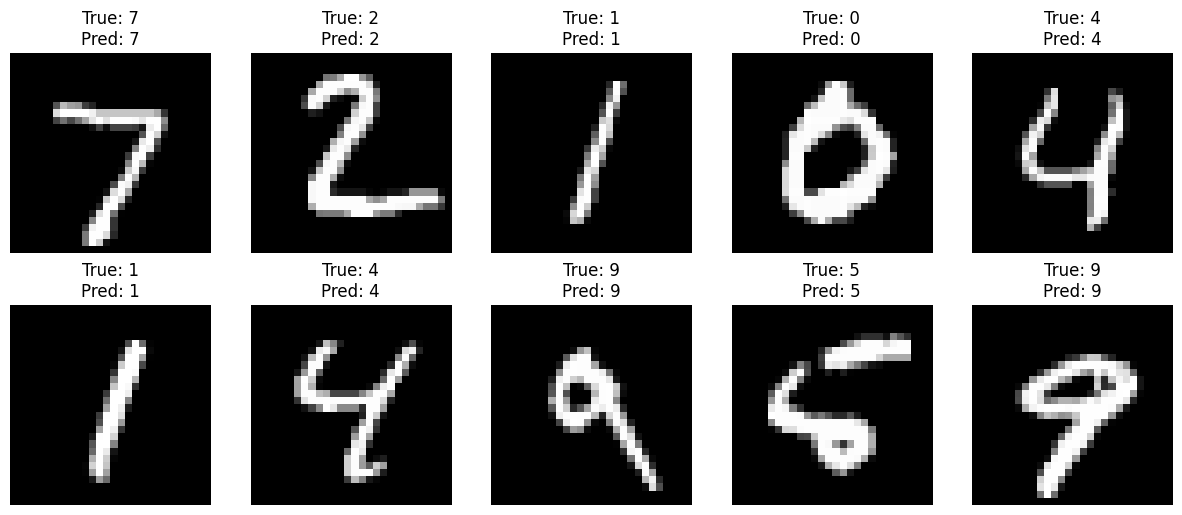

In [ ]:
# Visualize 10 samples and their predictions
csnn.eval()
with torch.no_grad():
    # Get 10 samples from test_loader
    sample_data, sample_target = next(iter(test_loader))
    sample_data = sample_data[:10].to(device)  # [10, 1, 28, 28]
    sample_target = sample_target[:10]  # [10]
    print(f"Sample data shape: {sample_data.shape}")

    # Convert to spike trains
    spike_data = csnn_rate_enc(sample_data, num_steps=50).to(device)  # [50, 10, 1, 28, 28]

    # Run inference
    spk_out = csnn(spike_data).sum(dim=0)  # [10, 10]
    predicted = torch.argmax(spk_out, dim=1).cpu()  # [10]

    # Plot 10 samples in a 2x5 grid
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_data[i, 0].cpu().numpy(), cmap='gray')
        plt.title(f'True: {sample_target[i].item()}\nPred: {predicted[i].item()}')
        plt.axis('off')


In [ ]:
print(f"test: {len(test_loader.dataset)}")
print(f"train: {len(train_loader.dataset)}")

test: 10000
train: 60000
